<a href="https://colab.research.google.com/github/ML-Oz/Oz-Python/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 수 와규 팀

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
filePath = '/content/drive/MyDrive/Colab Notebooks/기계학습팀플/Oz-Python/'

In [7]:
x_train = np.load(filePath + 'dataset/x_train.npy').astype(np.float32)
y_train = np.load(filePath + 'dataset/y_train.npy').astype(np.float32)
x_val = np.load(filePath + 'dataset/x_val.npy').astype(np.float32)
y_val = np.load(filePath + 'dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x = x_train, y = y_train,
    batch_size = 32,
    shuffle = True
)

val_generator = val_datagen.flow(
    x = x_val, y = y_val,
    batch_size = 32,
    shuffle = False
)

inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

In [12]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
      ModelCheckpoint('models/%s.h5' %(start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
      ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 0.4988 - acc: 0.7610
Epoch 00001: val_acc improved from -inf to 0.89583, saving model to models/2021_11_24_08_44_38.h5
81/81 [==============================] - 7s 72ms/step - loss: 0.4988 - acc: 0.7610 - val_loss: 0.2868 - val_acc: 0.8958 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.2888 - acc: 0.8797
Epoch 00002: val_acc improved from 0.89583 to 0.95833, saving model to models/2021_11_24_08_44_38.h5
81/81 [==============================] - 6s 70ms/step - loss: 0.2888 - acc: 0.8797 - val_loss: 0.1246 - val_acc: 0.9583 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.1854 - acc: 0.9323
Epoch 00003: val_acc improved from 0.95833 to 0.97917, saving model to models/2021_11_24_08_44_38.h5
81/81 [==============================] - 6s 70ms/step - loss: 0.1854 - acc: 0.9323 - val_loss: 0.0805 - val_acc: 0.9792 - lr: 0.0010
Epoch 4/50
81/81 [================

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

test acc: 1.0


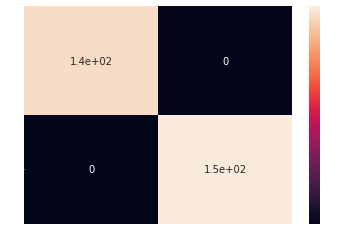

In [16]:
model = load_model('models/%s.h5' %(start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred>0.5).astype(np.int)

print('test acc: %s' %accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)